# BNN学習実装テスト

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import tensor_shape, ops
from tensorflow.python.ops import standard_ops, nn, variable_scope, math_ops, control_flow_ops
from tensorflow.python.eager import context
from tensorflow.python.training import optimizer, training_ops

In [7]:
tf.round(1.2)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [32]:
def hard_sigmoid(x):
    return tf.clip_by_value((x + 1.)/2., 0, 1)

def round_through(x):
    '''Element-wise rounding to the closest integer with full gradient propagation.
    A trick from [Sergey Ioffe](http://stackoverflow.com/a/36480182)
    a op that behave as f(x) in forward mode,
    but as g(x) in the backward mode.
    '''
    rounded = tf.round(x)
    return x + tf.stop_gradient(rounded-x)

# The neurons' activations binarization function
# It behaves like the sign function during forward propagation
# And like:
#   hard_tanh(x) = 2*hard_sigmoid(x)-1
# during back propagation
def binary_tanh_unit(x):
    return 2.*round_through(hard_sigmoid(x))-1.

def binary_sigmoid_unit(x):
    return round_through(hard_sigmoid(x))

def binaryzation(W, H, binary=True, deterministic=False, stochastic=False, srng=None):
    dim = W.get_shape().as_list()

    if not binary or (deterministic and stochastic):
        Wb = W
    else:
        Wb = H * binary_tanh_unit(W/H)

    return Wb

In [63]:
class BinaryDense(tf.keras.layers.Dense):
    def __init__(self, output_dim,
               activation = None,
               use_bias = True,
               binary = True, stochastic = True, H = 1., W_LR_scale="Glorot",
               kernel_initializer = tf.initializers.glorot_normal,
               bias_initializer = tf.initializers.zeros,
               kernel_regularizer = None,
               bias_regularizer = None,
               activity_regularizer = None,
               kernel_constraint = None,
               bias_constraint = None,
               trainable = True,
               name = None,
               **kwargs):
        super(BinaryDense, self).__init__(units = output_dim,
               activation = activation,
               use_bias = use_bias,
               kernel_initializer = kernel_initializer,
               bias_initializer = bias_initializer,
               kernel_regularizer = kernel_regularizer,
               bias_regularizer = bias_regularizer,
               activity_regularizer = activity_regularizer,
               kernel_constraint = kernel_constraint,
               bias_constraint = bias_constraint,
               trainable = trainable,
               name = name,
               **kwargs)

        self.binary = binary
        self.stochastic = stochastic

        self.H = H
        self.W_LR_scale = W_LR_scale

    def build(self, input_shape):
        num_inputs = tensor_shape.TensorShape(input_shape).as_list()[-1]
        num_units = self.units
        print(num_units)

        if self.H == "Glorot":
            self.H = np.float32(np.sqrt(1.5/(num_inputs + num_units)))
        self.W_LR_scale = np.float32(1. / np.sqrt(1.5 / (num_inputs + num_units)))
        print("H = ", self.H)
        print("LR scale = ", self.W_LR_scale)

        self.kernel_initializer = tf.random_uniform_initializer(-self.H, self.H)
        self.kernel_constraint = lambda w: tf.clip_by_value(w, -self.H, self.H)

        self.b_kernel = self.add_weight("binary_weight",
                                          shape=[input_shape[-1], self.units],
                                          initializer=tf.random_uniform_initializer(-self.H, self.H),
                                          regularizer=None,
                                          constraint=None,
                                          dtype=self.dtype,
                                          trainable=False)
        super(BinaryDense, self).build(input_shape)

        #tf.add_to_collection(self.name + "_binary", self.kernel)
        #tf.add_to_collection("binary", self.kenel)

    def call(self, inputs):
        inputs = ops.convert_to_tensor(inputs, dtype=self.dtype)
        shape = inputs.get_shape().as_list()

        self.b_kernel = binaryzation(self.kernel, self.H)

        print("shape: ", len(shape))

        if len(shape) > 2:
            outputs = standard_ops.tensordot(inputs, self.b_kernel, [[len(shape) - 1], 0])

            if context.in_eager_mode():
                outputs_shape = shape[:-1] + [self.units]
                outputs.set_shape(outputs_shape)
        else:
            outputs = standard_ops.matmul(inputs, self.b_kernel)

        if self.use_bias:
            outputs = nn.bias_add(outputs, self.bias)
        if self.activation is not None:
            return self.activation(outputs)
        return outputs

In [16]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [25]:
inputs = tf.keras.Input((28, 28))
x = tf.keras.layers.Flatten(input_shape=(28,28))(inputs)
x = BinaryDense(128)(x)
x = BinaryDense(10)(x)
model = tf.keras.Model(inputs, x)

128
H =  1.0
LR scale =  24.657656
shape:  2
10
H =  1.0
LR scale =  9.591663
shape:  2


In [28]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [29]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [30]:
model.fit(x_train, y_train, epochs=5)

Epoch 1/5


2022-09-27 12:01:29.609110: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-27 12:01:29.775932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


shape:  2
shape:  2
shape:  2
shape:  2
1875/1875 [==============================] - 11s 5ms/step - loss: 15.9183 - accuracy: 0.7404
Epoch 2/5
1875/1875 [==============================] - 9s 5ms/step - loss: 7.0185 - accuracy: 0.8490
Epoch 3/5
1875/1875 [==============================] - 9s 5ms/step - loss: 6.4827 - accuracy: 0.8584
Epoch 4/5
1875/1875 [==============================] - 9s 5ms/step - loss: 6.4361 - accuracy: 0.8634
Epoch 5/5
1875/1875 [==============================] - 9s 5ms/step - loss: 6.5074 - accuracy: 0.8648


In [64]:
bi_layer = model.layers[2]
w = bi_layer.get_weights()
w[1]

NameError: name 'model' is not defined

In [41]:
x_test = tf.keras.layers.Flatten(input_shape=(28,28))(inputs)
x_test = tf.keras.layers.Dense(128)(x_test)
x_test = tf.keras.layers.Dense(10)(x_test)
test_model = tf.keras.Model(inputs, x_test)

In [50]:
w1 = model.layers[2].get_weights()
w2 = model.layers[3].get_weights()
bi_w1 = [binary_tanh_unit(w1[0]), w1[1]]
bi_w2 = [binary_tanh_unit(w2[0]), w2[1]]

test_model.layers[2].set_weights(bi_w1)
test_model.layers[3].set_weights(bi_w2)

In [52]:
test_model.compile(optimizer='adam',
                    loss=loss_fn,
                    metrics=['accuracy'])
test_model.evaluate(x_train, y_train)

  48/1875 [..............................] - ETA: 6s - loss: 6.7303 - accuracy: 0.8548

2022-09-27 12:19:35.002300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 6s 3ms/step - loss: 6.4371 - accuracy: 0.8587


[6.437094211578369, 0.8587333559989929]

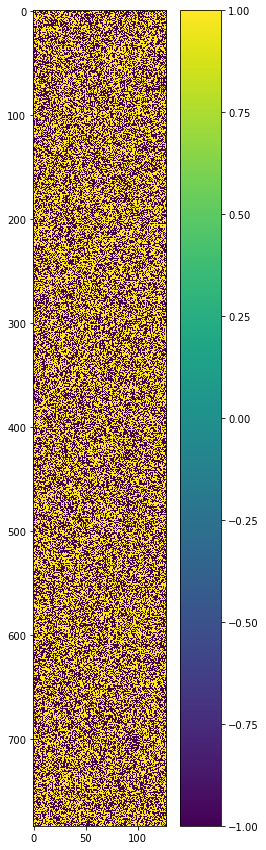

In [59]:
plt.figure(figsize=(5,15))
plt.imshow(test_model.layers[2].get_weights()[0], interpolation='none')
plt.colorbar()

実装はこれでOk

# BinarizedMO

In [1]:
import numpy as np
import tensorflow as tf
from Faraday.two_dim.module.lib.layers import *

In [62]:
x = tf.Variable(-1.)

with tf.GradientTape() as tape:
    bi_x = binaryzation(x, 1.)
    y = bi_x ** 2

print(tape.gradient(y, x))

tf.Tensor(-2.0, shape=(), dtype=float32)


In [30]:
x = tf.complex(1., 1.)
y = tf.complex(1., 1.)

with tf.GradientTape() as tape:
    tape.watch([x,y])
    x_ = 2. * tf.stop_gradient(x)
    z = x_ * y

print(tape.gradient(z, x))

None


In [4]:
class BynarizedMO(MO):
    def __init__(self,output_dim, theta=0.0, eta=0.0, kernel_regularizer=None):
        super(BynarizedMO, self).__init__(
            output_dim=output_dim,
            limitation=None,
            theta=theta,
            eta=eta,
            kernel_regularizer=kernel_regularizer
        )

    @tf.function
    def hard_sigmoid(self, x):
        return tf.clip_by_value((x + 1.)/2., 0, 1)

    @tf.function
    def round_through(self, x):
        '''Element-wise rounding to the closest integer with full gradient propagation.
        A trick from [Sergey Ioffe](http://stackoverflow.com/a/36480182)
        a op that behave as f(x) in forward mode,
        but as g(x) in the backward mode.
        '''
        rounded = tf.round(self, x)
        return x + tf.stop_gradient(rounded-x)

    # The neurons' activations binarization function
    # It behaves like the sign function during forward propagation
    # And like:
    #   hard_tanh(x) = 2*hard_sigmoid(x)-1
    # during back propagation
    @tf.function
    def binary_tanh_unit(self, x):
        return 2.*hard_sigmoid(self, x)-1.

    @tf.function
    def binary_sigmoid_unit(self, x):
        return round_through(hard_sigmoid(x))

    @tf.function
    def binaryzation(self, W, H, binary=True, deterministic=False, stochastic=False, srng=None):
        if not binary or (deterministic and stochastic):
            Wb = W
        else:
            Wb = tf.stop_gradient(H * binary_tanh_unit(W/H))

        return Wb

    def build(self, input_shape):
        self.kernel_initializer = tf.random_uniform_initializer(-1., 1.)
        self.kernel_constraint = lambda w: tf.clip_by_value(w, -1., 1.)
        super(BynarizedMO, self).build(input_shape)

    def call(self, inputs):
        bi_mag = self.binaryzation(self.mag, 1.)
        theta = tf.complex(self.theta * bi_mag, tf.zeros_like(bi_mag))
        eta = self.eta * bi_mag

        rcp_x = tf.keras.layers.Lambda(lambda x: x[:, 0, :, :])(inputs)
        lcp_x = tf.keras.layers.Lambda(lambda x: x[:, 1, :, :])(inputs)

        rcp_x_mo = tf.complex((1.0 + eta)/(1.0 + self.eta_max), tf.zeros_like(self.mag)) * rcp_x * tf.exp(-1.0j * theta)
        lcp_x_mo = tf.complex((1.0 - eta)/(1.0 + self.eta_max), tf.zeros_like(self.mag)) * lcp_x * tf.exp(1.0j * theta)

        return tf.stack([rcp_x_mo, lcp_x_mo], axis=1)

In [5]:
def create_model(**kwargs):
    shape = (100, 100)
    inputs = tf.keras.Input((28, 28))
    x = ImageResizing(shape)(inputs)
    x = IntensityToElectricField(shape)(x)
    x = BynarizedMO(shape, theta=np.pi/2, eta=0.1)(x)
    x = AngularSpectrum(shape, wavelength=633e-9, z=0.5e-3, d=1.0e-6, n=1., method='expand')(x)
    x = ElectricFieldToIntensity(shape)(x)
    x = MNISTDetector(10)(x)
    x = tf.keras.layers.Softmax()(x)
    model = tf.keras.Model(inputs, x)
    return model

In [6]:
model = create_model()

Metal device set to: Apple M1


2022-10-03 12:39:44.317855: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-03 12:39:44.318217: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


AttributeError: 'BynarizedMO' object has no attribute 'initializer'

In [103]:
np.min(model.layers[3].get_weights()[0])

-0.32723445

In [108]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5)

Epoch 1/5


2022-09-27 15:40:34.117609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 412/1875 [=====>........................] - ETA: 2:02 - loss: 2.3018 - accuracy: 0.1397

KeyboardInterrupt: 